# Area Under the Curve (AUC)

Common approaches for evaluating a classifier involve metrics such as *accuracy*, *precision*, *recall*, and *F1*. In addition to these, another powerful approach is to compute the **Area Under the Curve** (AUC). In this notebook, we'll cover the AUC for the *Receiver Operating Characteristic* (ROC) and *Precision-Recall* (PR) profiles for binary classification problems. 

## Why use the AUC?

You might be wondering why do we need a AUC metric? Answering this requires a bit of understanding for how classifiers work. Under the hood, all classifiers are designed to predict discrete labels based on patterns learned on some training set. These discrete values are normally integers such as 0, 1, 2, etc. Machine learning models do not directly produce discrete values however, but instead yield probabilities for each class in the training data. A cutoff *threshold* is then used to convert these probabilities into the discrete class labels.

AUC metrics provide a way to evaluate the performance of a classifier, **independent of the threshold choice**. This enables us to have a much more robust sense for how well the classifier is working. The AUC value ranges from 0.0 (worst) to 1.0 (best).

In addition, the associated ROC or PR profiles can be used to optimally select a threshold value based on the problem at hand.

## ROC AUC

The ROC plots the *True Positive Rate* (TPR) over the *False Positive Rate* (FPR). These quantities are given by:

$$TPR = \frac{TP}{TP+FN}$$

$$FPR = \frac{FP}{FP+TN}$$

where $TP$, $FP$, $TN$, and $FN$ are the true positive, false positive, true negative, and false negative counts, respectively. Note that the $TPR$ is the same as recall.

Let's now create a simple dataset, do a train-test split, and use an xgboost classifier to attempt to model it:

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, 
    roc_auc_score,
    auc,
    precision_recall_curve,
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [2]:
X, y = make_classification(n_samples=1000, n_features=8, n_classes=2, weights=[0.6, 0.4], return_X_y=True, random_state=42)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [4]:
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


This was straightforward enough, now let's attempt to analyse the performance of this model on the test set:

In [5]:
y_prob = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])

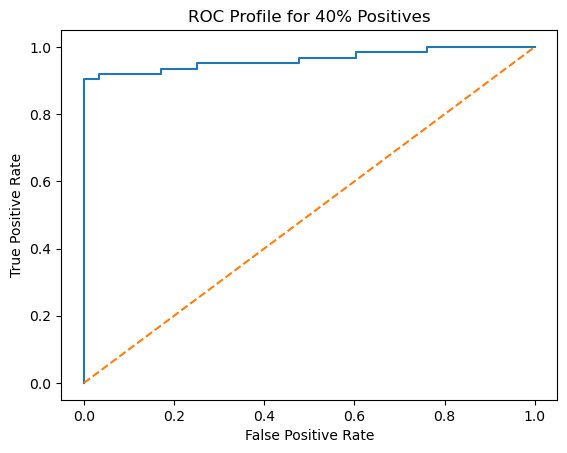

In [6]:
plt.plot(fpr, tpr)
plt.title('ROC Profile for 40% Positives')
plt.plot([0,1], ls="--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

The blue curve in the plot above shows how the $TPR$ and $FPR$ vary, as the cutoff threshold varies from 0.0 to 1.0. For a perfect classifier, this curve would shoot to 1.0 for $FPR = 0.0$. The orange diagnonal line represents the performance expected for random guessing.

We can see that our classifier is functioning quiet well: the $TPR$ jumps above 0.8 even for very low $FPR$ values.

To quantify the plotted results, let's compute the ROC AUC. The ROC AUC is the area under the blue curve. We can do this with a single function call:

In [7]:
roc_auc_score(y_test, y_prob[:,1])

0.9629765395894428

A result of ~0.96 shows that our classifier is functioning very well on the test set.

Now how can class imbalance effect the results above? If we look back to how we made our dataset, we introduced only a mild class imbalance of 0.6/0.4. There are many practical problems where the imbalance can be far more severe. How does our model perform then?

In [8]:
X, y = make_classification(n_samples=1000, n_features=8, n_classes=2, weights=[0.99, 0.01], return_X_y=True, random_state=42)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [10]:
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [11]:
y_prob = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])

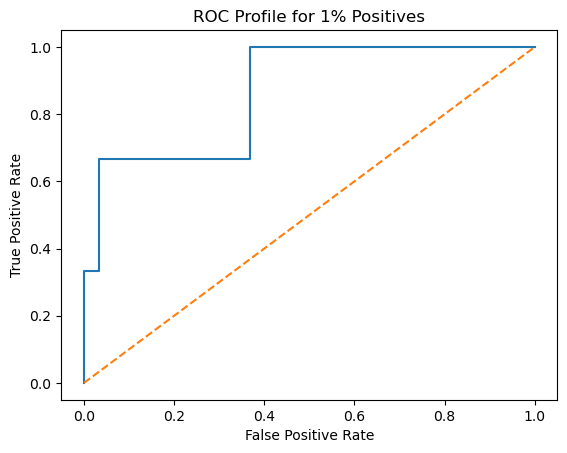

In [12]:
plt.plot(fpr, tpr)
plt.title('ROC Profile for 1% Positives')
plt.plot([0,1], ls="--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [13]:
roc_auc_score(y_test, y_prob[:,1])

0.8662131519274376

We can see model performance has dropped off, and understandably so. However, it is still not that bad, considering we only have 1% positives. 

But wait a minute, just how representative are these results now to the true performance of the classifier? More specifically, let's look again at our definition for $FPR$. In general, small values of $FPR$ are good, showing that we have a small number of false positives. However, in the scenario we have above, $FPR$ will always be small since the 99% of our data consist of negative values (represented by the $TN$ term in the denominator). As such, using the $FPR$ does not make much sense in case. 

## PR AUC

For situations of high class imbalance, we can replace the $FPR$ with *precision*, defined as:

$$precision = \frac{TP}{TP+FP}$$

Precision measures the ability of the classifier to correctly identify positive values. Remember also that the $TPR$ is the *recall*, which measures the ability of the model find all positive values.

The PR plot can then be generated in a manner that is analogous to what we did earlier:

In [14]:
precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])

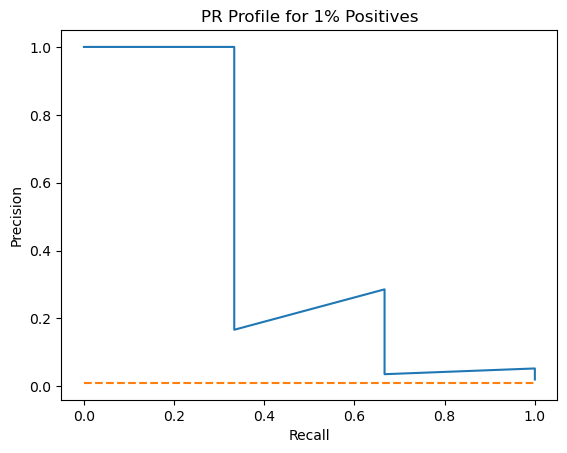

In [15]:
plt.plot(recall, precision)
plt.title('PR Profile for 1% Positives')
plt.plot([0.01,0.01], ls="--")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

Here recall is now on the x-axis, and precision is placed on the y-axis. The better the classifier, the more the blue curve will shift to the top right (and cover more area in the figure). Our baseline is now presented by a horizontal line, set at the ratio of positives for our data (1%). This is the minimal precision possible, assuming we label all samples positive.

We can now compute the area under this curve:

In [16]:
auc(recall, precision)

0.4234544695071011

This value is considerably lower than what we saw earlier, and gives a better sense for how the model is *at finding positive values* in the test set. Note that the PR AUC primarily reflects a classifiers ability to identify positive labels.

## Conclusion

We worked through 2 different AUC metrics for evaluating a classification model. Both represent ways to measure model performance independent of the choice of cutoff threshold value.
1. The ROC AUC is better suited for problems where class imbalance is not significant, and we are interested is correctly identifying both labels
2. The PR AUC more appropriate for problems with significant class imbalance, and where we are primarily interested in identifying the positive (minority) class correctly. This is typically the case in many real-world problems such as fraud detection, spam email identification, etc.